In [1]:
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW, AutoModelForQuestionAnswering, AutoTokenizer
import os
import re
import string
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
import import_ipynb
import extract_transform_evaluate as fn

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def train_model(self, dataloader, optimizer):
    self.train()
    accuracy_arr, loss_arr = [], []
    for batch in tqdm(dataloader, desc='Training Started!'):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(self.device)
        attention_mask = batch['attention_mask'].to(self.device)
        start_pos = batch['start_positions'].to(self.device)
        end_pos = batch['end_positions'].to(self.device)
        start_res, end_res = self(input_ids=input_ids, attention_mask=attention_mask)
        loss = self.find_focal_loss(start_res, end_res, start_pos, end_pos)
        loss_arr.append(loss.item())
        loss.backward()
        optimizer.step()

        start_pred = torch.argmax(start_res, dim=1)
        end_pred = torch.argmax(end_res, dim=1)

        accuracy_arr.append(((start_pred == start_pos).sum()/len(start_pred)).item())
        accuracy_arr.append(((end_pred == end_pos).sum()/len(end_pred)).item())

    return sum(accuracy_arr)/len(accuracy_arr), sum(loss_arr)/len(loss_arr)

def plot_metrics(epochs, train_losses, train_accuracies, wer_scores, f1_scores):
    metrics = {
        'Training Loss': train_losses,
        'Training Accuracy': train_accuracies,
        'Word Error Rate (WER)': wer_scores,
        'F1 Score': f1_scores
    }
    colors = ['blue','green','red','brown']
    plt.figure(figsize=(12, 8))
    
    # Loop over metrics dictionary to create subplots
    for i, (title, values) in enumerate(metrics.items(), start=1):
        plt.subplot(2, 2, i)
        plt.plot(epochs, values, marker='o', linestyle='-', color=colors[i-1])
        plt.title(title)
        plt.xlabel('Epoch')
        plt.ylabel(title.split()[1])
    
    plt.tight_layout()
    plt.show()

Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/home/lmadipa/.conda/envs/pytorch_env/lib/python3.11

Epoch - 1


Training Started!: 100%|██████████| 2320/2320 [06:33<00:00,  5.89it/s]


Train Accuracy: 0.4319234913921562 and Train Loss: 1.988135942174443


Evaluating Model!: 100%|██████████| 15875/15875 [01:19<00:00, 199.00it/s]


F1 Score: 0.6104037482612746 and WER Score: 1.3063737324963787
Epoch - 2


Training Started!: 100%|██████████| 2320/2320 [06:34<00:00,  5.88it/s]


Train Accuracy: 0.6148995535801454 and Train Loss: 1.097670018608714


Evaluating Model!: 100%|██████████| 15875/15875 [01:19<00:00, 199.36it/s]


F1 Score: 0.6366261413866339 and WER Score: 1.188537681536233
Epoch - 3


Training Started!: 100%|██████████| 2320/2320 [06:34<00:00,  5.88it/s]


Train Accuracy: 0.7061999692228333 and Train Loss: 0.73288844470577


Evaluating Model!: 100%|██████████| 15875/15875 [01:19<00:00, 198.98it/s]


F1 Score: 0.643842474611175 and WER Score: 1.1951305575158786
Epoch - 4


Training Started!: 100%|██████████| 2320/2320 [06:34<00:00,  5.88it/s]


Train Accuracy: 0.7801570197246198 and Train Loss: 0.48573300792225477


Evaluating Model!: 100%|██████████| 15875/15875 [01:19<00:00, 198.96it/s]


F1 Score: 0.6461018134121581 and WER Score: 1.0564573041637262
Epoch - 5


Training Started!: 100%|██████████| 2320/2320 [06:34<00:00,  5.88it/s]


Train Accuracy: 0.8325835129310345 and Train Loss: 0.3343816852670741


Evaluating Model!: 100%|██████████| 15875/15875 [01:19<00:00, 198.95it/s]


F1 Score: 0.6307734369672022 and WER Score: 1.0645916131188946
Epoch - 6


Training Started!: 100%|██████████| 2320/2320 [06:34<00:00,  5.88it/s]


Train Accuracy: 0.8705030018656418 and Train Loss: 0.23786105500084573


Evaluating Model!: 100%|██████████| 15875/15875 [01:19<00:00, 199.65it/s]


F1 Score: 0.6362215826124291 and WER Score: 1.1515804330869517


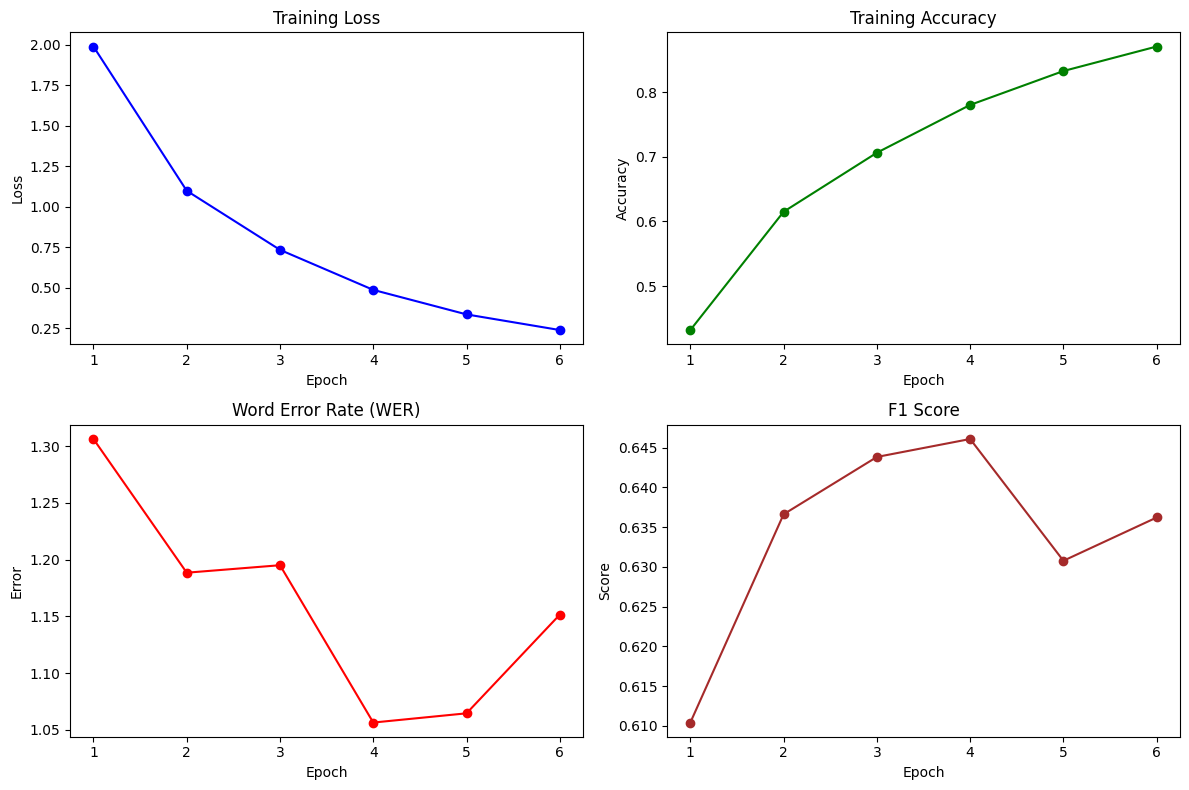

In [2]:
train_data = '../spoken_train-v1.1.json'
test_data = '../spoken_test-v1.1.json'
MODEL_PATH = "distilbert-base-uncased"
MODEL_SAVE_PATH = "qa_simple_model"

tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)

train_encodings = fn.collect_and_find_positions(train_data, tokenizer, 512)
test_encodings = fn.collect_and_find_positions(test_data, tokenizer, 512)

train_set = fn.SpokenSquad(train_encodings)
test_set = fn.SpokenSquad(test_encodings)
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
test_loader = DataLoader(test_set, batch_size=1)

distilbert_base_uncased__model = AutoModelForQuestionAnswering.from_pretrained(MODEL_PATH)
qa_model = fn.QAModel(distilbert_base_uncased__model, device)
optimizer = AdamW(qa_model.parameters(), lr=2e-5, weight_decay=0.02)

wer_scores, accuracies, losses, f1_scores  = [], [], [], []

epoch = 0
if not os.path.exists(MODEL_SAVE_PATH):
    os.makedirs(MODEL_SAVE_PATH)

while epoch < 6:
    print(f'Epoch - {epoch + 1}')
    
    accuracy, loss = train_model(qa_model, train_loader, optimizer)
    accuracies.append(accuracy)
    losses.append(loss)
    print(f"Train Accuracy: {accuracy} and Train Loss: {loss}")

    avg_f1_score, wer_score = qa_model.evaluate_model(test_loader, tokenizer)
    f1_scores.append(avg_f1_score)
    wer_scores.append(wer_score)
    print(f"F1 Score: {avg_f1_score} and WER Score: {wer_score}")

    epoch += 1

torch.save(qa_model.state_dict(), os.path.join(MODEL_SAVE_PATH, 'model_weights.pt'))
tokenizer.save_pretrained(MODEL_SAVE_PATH)

plot_metrics(range(1, 7), losses, accuracies, wer_scores, f1_scores) 